# 20 Newsgroups: Feature Engineering

User Guide:

* [1.1.5. Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net): "Elastic-net is useful when there are multiple features that are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both." (scikit-learn 1.1.0)
   * Learning curves, nur `lasso_path()` und `enet_path()`: [Lasso and Elastic Net](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py) (scikit-learn 1.1.0)
   
* [1.1.6. Multi-task Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#multi-task-elastic-net)

Reference:

* [sklearn.linear_model.ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)

* [sklearn.linear_model.ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV)

* [sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier): "Implements logistic regression with elastic net penalty (SGDClassifier(loss="log_loss", penalty="elasticnet"))."


In [1]:
from time import time

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = [ "rec.autos",
    "rec.motorcycles" ]

categories1 = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
     'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
]

* http://qwone.com/~jason/20Newsgroups/
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
* https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset

In [3]:
data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42,
    remove = ('headers', 'footers', 'quotes')  # hinzugefügt JB
)

data_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42,
    remove = ('headers', 'footers', 'quotes')   # hinzugefügt JB
)
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (len(data_test.data), data_test_size_mb))

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names
print("%d categories:" % len(target_names), target_names)

1192 documents - 0.776MB (training set)
794 documents - 0.443MB (test set)
2 categories: ['rec.autos', 'rec.motorcycles']


`data_train` ist ein Dictionary; `data_train['data']` ist eine Liste von Strings:

In [22]:
data_train['data'][:3]

['Stuff deleted...',
 "This morning a truck that had been within my sight (and I within\nhis) for about 3 miles suddenly forgot that I existed and pulled\nover right on me -- my front wheel was about even with the back\nedge of his front passenger door as I was accelerating past him.\n\nIt was trivial enough for me to tap the brakes and slide behind him\nas he slewed over (with no signal, of course) on top of me, with\nmy little horn blaring (damn, I need Fiamms!), but the satisfaction\nof being aware of my surroundings and thus surviving was not enough,\nespecially when I later pulled up alongside the bastard and he made\nno apologetic wave or anything.\n\nIs there some way that I can memorize the license plate of an\noffending vehicle and get the name and address of the owner?\nI'm not going to firebomb houses or anything, I'd just like to\nwrite a consciousness-raising letter or two. I think that it would\nbe good for BDI cagers to know that We Know Where They Live.\nMaybe they'd us

`data_train['target']` ist eine Liste von Zahlen, die die Kategorien repräsentieren:

In [5]:
data_train['target']

array([0, 1, 1, ..., 0, 1, 0])

Abbildung von den als Zahlen repräsentierten Kategorien im Target auf die Kategorien als Strings:

In [6]:
num_to_categoy = dict(zip(set(data_train['target']), target_names))
num_to_categoy

{0: 'rec.autos', 1: 'rec.motorcycles'}

Übliche Nomenklatur: 

* `X` ... Features als Matrix
* `y` ... Target als Vektor

Wir wollen die Wirkung von Varianten des Feature-Enginerings vergleichen. Also legen wir ein Dict für die verschiedenen Varianten der X-Matrix an.

In [7]:
# maximum of docs to be considered
# use len(data_train.data) to process all available docs

n_max_docs =  100 # alle: len(data_train['target'])

In [8]:
y = data_train['target'][:n_max_docs]

X_train = { 'unmodified': data_train['data'][:n_max_docs] }
X_train['unmodified'][:2]

['Stuff deleted...',
 "This morning a truck that had been within my sight (and I within\nhis) for about 3 miles suddenly forgot that I existed and pulled\nover right on me -- my front wheel was about even with the back\nedge of his front passenger door as I was accelerating past him.\n\nIt was trivial enough for me to tap the brakes and slide behind him\nas he slewed over (with no signal, of course) on top of me, with\nmy little horn blaring (damn, I need Fiamms!), but the satisfaction\nof being aware of my surroundings and thus surviving was not enough,\nespecially when I later pulled up alongside the bastard and he made\nno apologetic wave or anything.\n\nIs there some way that I can memorize the license plate of an\noffending vehicle and get the name and address of the owner?\nI'm not going to firebomb houses or anything, I'd just like to\nwrite a consciousness-raising letter or two. I think that it would\nbe good for BDI cagers to know that We Know Where They Live.\nMaybe they'd us

## Feature Eingineering

### spaCy

Einlesen: <https://spacy.io/usage/spacy-101>

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [10]:
def token_filter(token):
    return not (token.is_punct 
                | token.is_space 
                #| token.is_stop 
                | token.is_bracket
                | len(token.text) < 3
               )
    
def nlp_with_token_filter(doc):
    d = nlp(doc)
    return " ".join( f"{token.lemma_}"  # f"{token.pos_}_{token.lemma_}"
                    for token in d if token_filter(token) )

In [11]:
t0 = time()
X_train['nlp_with_token_filter'] = [ nlp_with_token_filter(doc) 
                                    for doc in X_train['unmodified'][0:n_max_docs] ]
duration = time() - t0
print(f"{n_max_docs} docs in {duration:.2f} seconds")

100 docs in 2.06 seconds


## Bag of Words


Theorie zum Einlesen und viel mehr: <https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html> (<https://opac.haw-landshut.de/TouchPoint/perma.do?q=1035%3D%22BV045113643%22+IN+%5B3%5D&v=fla&l=de>)

* 
[sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html): "Equivalent to CountVectorizer followed by TfidfTransformer":  Weil wir beide Schritte unabhängig voneinander untersuchen wollen, wenden wir beide separat an.

### count vectorizer


* [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)


In [12]:
flavours = [ 'unmodified', 'nlp_with_token_filter' ]

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
X_vectorizer = {}
X_bag_of_words = {}

In [14]:
for flavour in flavours: 
    X_vectorizer[flavour] = CountVectorizer(strip_accents='unicode')
    X_bag_of_words[flavour] = X_vectorizer[flavour].fit_transform(X_train[flavour])
    print(f"{flavour}: {X_bag_of_words[flavour].shape}")

unmodified: (100, 2917)
nlp_with_token_filter: (100, 2419)


In [15]:
def inspect_feature_names(start_filter):
    for flavour in flavours:
        feature_names = [ f for f in X_vectorizer[flavour].get_feature_names_out() 
                              if f.startswith(start_filter)]
        print(f"\n{flavour}, {len(feature_names)} items: {feature_names}")

inspect_feature_names("ea")


unmodified, 7 items: ['each', 'eagle', 'ease', 'easier', 'easily', 'easy', 'eaten']

nlp_with_token_filter, 6 items: ['each', 'eagle', 'ease', 'easily', 'easy', 'eat']


In [16]:
for flavour in flavours:
    print(f"{flavour}: {X_bag_of_words[flavour].shape}")

unmodified: (100, 2917)
nlp_with_token_filter: (100, 2419)


### transformer

* [sklearn.feature_extraction.text.TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)


In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
X_transformer = {}
X_tfidf = {}

In [18]:
for flavour in flavours: 
    X_transformer = {flavour: CountVectorizer(strip_accents='unicode') }
    X_tfidf[flavour] = X_transformer[flavour].fit_transform(X_train[flavour])
    print(f"{flavour}: {X_tfidf[flavour].shape}")

unmodified: (100, 2917)
nlp_with_token_filter: (100, 2419)


## SGDClassifier als Elastic Net

Eigentlich interessiert uns Klassifikation (aka Logistische Regression) mit ElasticNet. Weil ElasticNet aber nur eine Regression ist (und erst nach Anwendung eines Schwellwerts als Klassifikation taugt), nutzen wir die Logistische Regression-Klassifikation, die im SGDClassifier eingebaut ist:

> [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier): Implements logistic regression with elastic net penalty (SGDClassifier(loss="log_loss", penalty="elasticnet")). <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html>

SGDClassifier: 
* user guide: <https://scikit-learn.org/stable/modules/sgd.html#sgd>
* Referenz: <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier>

In [19]:
from sklearn.linear_model import SGDClassifier
X_SGDClassifier_clf = {}

In [20]:
for flavour in flavours: 
    X_SGDClassifier_clf[flavour] = SGDClassifier(
        random_state=0, 
        # loss="log_loss", # ValueError: The loss log_loss is not supported.  
        penalty="elasticnet")
    X_SGDClassifier_clf[flavour].fit(X_tfidf[flavour], y)
    

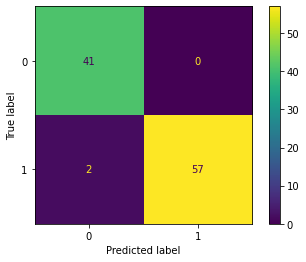

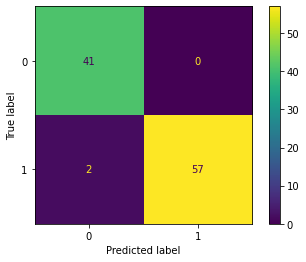

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

for flavour in flavours:
    ConfusionMatrixDisplay.from_predictions(
        X_SGDClassifier_clf[flavour].predict(X_tfidf[flavour]), y)

ACHTUNG: Diese Confusion-Matritzen sehen gut aus. ABER das sind *in training tests* mit Overfitting,  keine Tests gegen unbekannte Daten.

Noch zu tun: mit der selben Pipeline Testdaten bearbeiten, dann ernsthafte Confusion Matrix. 